# 长期价值投资数据监测

In [1]:
#imports

import yfinance as yf
import pandas as pd
import datetime as dt
import seaborn as sns
from  matplotlib import pyplot as plt

#init
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, 
            rc={'figure.figsize':(15,10)})
#pd.options.display.float_format = '{:,.2f}'.format

#parameters
ticker_list=['FB','MSFT','AAPL','GOOG','AMZN','BABA',
'NVDA','0700.HK','ADBE','MO','ADSK','ASML','BRK-B',
'GS','ISRG','KO','LVMUY','2318.HK','TSM','ADBE','MCO','1810.HK',
'3690.HK'

]



In [2]:
print('This notebook was refreshed at %s'%(dt.datetime.now()))

This notebook was refreshed at 2022-01-06 11:33:43.049935


## 美国国债收益率监测

In [3]:
df_rate=pd.DataFrame()
data=yf.download(['^IRX','^FVX','^TNX','^TYX'],progress=False)

df_rate=data.loc[dt.date.today()-dt.timedelta(days=365*10):]['Close']
df_rate.columns=['5 Years','13 Weeks','10 Years','30 Years']

In [4]:
s=df_rate.tail(1).style.format('{:.3f}%')
s

,5 Years,13 Weeks,10 Years,30 Years
Date,,,,
2022-01-05 00:00:00,1.433%,0.085%,1.705%,2.088%


Text(0.5, 1.0, '10 years trend of treasury yield')

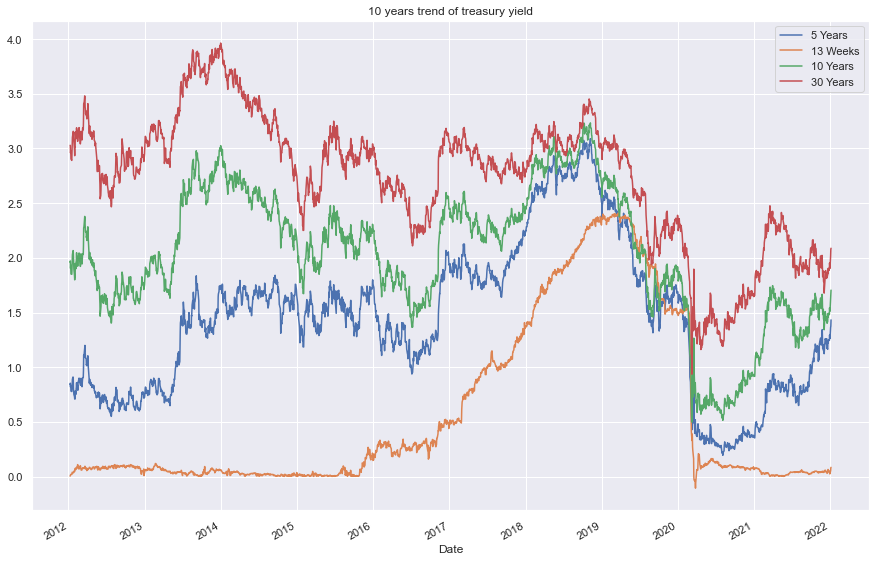

In [5]:
df_rate.plot()
plt.title("10 years trend of treasury yield")

## 股市和国债利率的相关度

## 跟踪公司数据监控

In [6]:

ticker_list=list(dict.fromkeys(ticker_list))

In [7]:
def get_stock_info(ticker):
    stock_info={}
    df=yf.download(ticker,start=dt.date.today()-dt.timedelta(days=366),auto_adjust=True,progress=True)
    stock_info=yf.Ticker(ticker).info
    stock_info['1w_chg_pct']=100*(df.loc[max(df.index)-dt.timedelta(weeks=1):,'Close'][-1]/df.loc[max(df.index)-dt.timedelta(weeks=1):,'Close'][0]-1)
    stock_info['1m_chg_pct']=100*(df.loc[max(df.index)-dt.timedelta(days=30):,'Close'][-1]/df.loc[max(df.index)-dt.timedelta(days=30):,'Close'][0]-1)
    stock_info['1y_chg_pct']=100*(df.loc[max(df.index)-dt.timedelta(days=365):,'Close'][-1]/df.loc[max(df.index)-dt.timedelta(days=365):,'Close'][0]-1)
    stock_info['max_drawdown']=100*(df.Close[-1]/max(df.Close)-1)
    stock_info['ticker']=ticker
    return stock_info


In [ ]:
df_stock=pd.DataFrame()
for ticker in ticker_list:
    try:
        stock_info=get_stock_info(ticker)
        df_stock=df_stock.append(stock_info,ignore_index=True)
    except:
        pass

df_stock['ratecode']=df_stock['financialCurrency']+'-'+df_stock['currency']
df_stock['ratecode']
df_stock['USD-USD']=1
df_stock['CNY-USD']=0.16
df_stock['TWD-USD']=0.036
df_stock['CNY-HKD']=1.22
df_stock['EUR-USD']=1.13
df_stock['rate']=df_stock['USD-USD'].where(df_stock['ratecode']=='USD-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['CNY-USD'].where(df_stock['ratecode']=='CNY-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['TWD-USD'].where(df_stock['ratecode']=='TWD-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['EUR-USD'].where(df_stock['ratecode']=='EUR-USD')
df_stock.loc[df_stock['rate'].isna(),['rate']]=df_stock['CNY-HKD'].where(df_stock['ratecode']=='CNY-HKD')
df_stock[['ticker','currency','financialCurrency','rate']]

In [9]:
df_vi_metric=pd.DataFrame()

df_vi_metric['ticker']=df_stock['ticker']
df_vi_metric['last_price']=df_stock['currentPrice']
df_vi_metric['target_price']=df_stock['targetMeanPrice']
df_vi_metric['1y_drawdown']=100*(df_stock['currentPrice']/df_stock['fiftyTwoWeekHigh']-1)
df_vi_metric['pcf']=df_stock['marketCap']/(df_stock['operatingCashflow']*df_stock['rate'])
df_vi_metric['pe_fwd']=df_stock['forwardPE']
df_vi_metric['revenue_growth']=df_stock['revenueGrowth']
df_vi_metric['cash_return_rate']=(df_stock['operatingCashflow']*df_stock['rate'])/df_stock['enterpriseValue']*100
df_vi_metric['roe']=df_stock['returnOnEquity']*100
df_vi_metric['gross_margin']=df_stock['grossMargins']*100
df_vi_metric['net_margin']=df_stock['profitMargins']*100
df_vi_metric['cf_margin']=df_stock['operatingCashflow']/df_stock['totalRevenue']*100
df_vi_metric['ps_ttm']=df_stock['priceToSalesTrailing12Months']
df_vi_metric['pe_ttm']=df_stock['currentPrice']/df_stock['trailingEps']
df_vi_metric['pb']=df_stock['priceToBook']
df_vi_metric['1m_chg_pct']=df_stock['1m_chg_pct']
df_vi_metric=df_vi_metric.set_index('ticker')

In [10]:
df_vi_metric.sort_values(by='pcf',inplace=True)
df_vi_metric.style.format(precision=2)
df_vi_metric.sort_values(by='1y_drawdown')

,last_price,target_price,1y_drawdown,pcf,pe_fwd,revenue_growth,cash_return_rate,roe,gross_margin,net_margin,cf_margin,ps_ttm,pe_ttm,pb,1m_chg_pct
ticker,,,,,,,,,,,,,,,
3690.HK,195.00,318.96,-57.608696,-1020.507771,-191.17647,0.381,-0.107935,-17.781000,23.382000,-12.277999,-0.577109,7.185121,NaN,11.747695,-16.049909
BABA,121.16,208.75,-55.827774,10.461664,12.516529,0.294,17.370296,11.253000,38.781000,15.305000,24.152881,0.404287,17.024027,0.339165,-1.974106
1810.HK,17.62,28.3,-50.644258,31.139654,14.561984,0.082,3.590252,22.260000,17.538000,8.194999,3.697715,1.404776,NaN,3.259944,-6.276154
0700.HK,420.00,617.43,-45.841393,19.133143,21.705425,0.135,4.744693,24.270001,44.959998,34.419000,31.441288,7.339162,38.133008,4.675967,-3.840996
2318.HK,56.90,87.77,-45.077220,9.382262,14.225,0.023,8.899258,14.309000,35.908002,9.119000,7.305343,0.836196,6.054367,1.304149,1.974863
ADBE,514.43,671.75,-26.461675,NaN,31.65723,0.200,NaN,34.368000,88.185000,30.548000,NaN,15.506227,51.340319,16.548607,-17.299529
ADSK,264.32,329.81,-23.249804,39.658459,38.699856,0.182,2.34757,195.552990,91.737000,31.305000,34.79117,13.797642,44.588394,45.478325,-0.466934
NVDA,276.04,342.16,-20.327878,84.486817,52.982727,0.503,1.123377,41.939998,64.398000,33.806000,33.542062,28.338621,85.118717,29.020185,-8.100006
ASML,745.67,868.79,-16.771400,29.477981,38.08325,0.324,3.238642,43.258998,52.124000,30.540000,50.891524,16.952026,49.655058,26.443136,-1.417262
